In [1]:
import os
import pandas as pd
import numpy as np
import nltk
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from textblob import TextBlob

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


## Preliminary Data Exploration

Initial steps to discover what our dataset consists of, and what does it look like. Took out everything before the year 2000, there were a small handful of dates set to 1980 which I believe were due to poor date parsing or other errors.

In [2]:
df = pd.read_csv('enron_test.csv', parse_dates=['new_date'])
df = df[df.new_date.dt.year >= 2000]
df.describe()

,Date,From,To,Subject,content,new_date
count,991,991,986,692,991,991
unique,647,41,226,344,650,647
top,"Tue, 6 Jun 2000 05:27:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'ina.rangel@enron.com'}),Re:,"Mary,\n\n I transferred $10,000 out of the che...",2000-08-20 17:39:00
freq,4,937,66,52,2,4
first,NaN,NaN,NaN,NaN,NaN,2000-01-04 19:39:00
last,NaN,NaN,NaN,NaN,NaN,2001-05-14 23:39:00


In [3]:
df.head()

,Date,From,To,Subject,content,new_date
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),NaN,Here is our forecast\n\n,2001-05-14 23:39:00
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,Traveling to have a business meeting takes the...,2001-05-04 20:51:00
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),Re: test,test successful. way to go!!!,2000-10-18 10:00:00
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),NaN,"Randy,\n\n Can you send me a schedule of the s...",2000-10-23 13:13:00
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Re: Hello,Let's shoot for Tuesday at 11:45.,2000-08-31 12:07:00


Now that we know what our data structure looks like, we can perform some basic analytics on the contents of this dataset. Of chief interest are the `Subject` and `content` fields, this is where the meat of any natural language processing will take place. We can begin by exploring the lengths of these fields, seeing what the distribution looks like and allowing us to estimate the size of these emails/documents.

Something of note is that there are only **41** possible email authors, so it seems as though this dataset may be more focused than it initially appears.

count      991.000000
mean       923.702321
std       1759.036329
min          2.000000
25%        121.000000
50%        371.000000
75%        926.500000
max      16395.000000
Name: content, dtype: float64

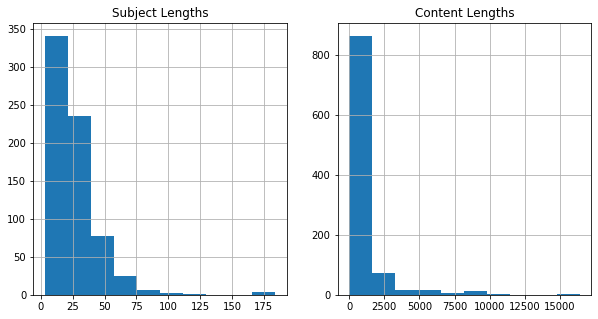

In [4]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1,2,1)
plt.title('Subject Lengths')
df['Subject'].str.len().hist()
plt.subplot(1,2,2)
plt.title('Content Lengths')
df['content'].str.len().hist()
df['content'].str.len().describe()

As expected, our email body's are far longer than the subjects, with a heavy skew for both towards shorter lengths. There's a handful of exceptionally long emails, 15000 characters+, but the majority are a thousand  or less. 

count     41.000000
mean      24.170732
std      146.126299
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      937.000000
dtype: float64

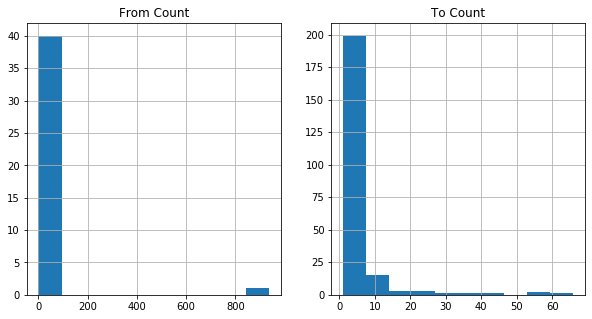

In [5]:
plt.subplot(1,2,1)
plt.title('From Count')
df.groupby('From').size().hist()
plt.subplot(1,2,2)
plt.title('To Count')
df.groupby('To').size().hist()
df.groupby('From').size().describe()

It looks like the vast majority of our emails are from only a tiny handful of people, and while there's a bit more diversity in who the emails are sent to, there doesn't seem to be an exceptionally large number.

## To's and From's

In [6]:
df.groupby('To').size().sort_values(ascending=False).head(10)

To
frozenset({'ina.rangel@enron.com'})          66
frozenset({'stagecoachmama@hotmail.com'})    59
frozenset({'jsmith@austintx.com'})           59
frozenset({'pallen70@hotmail.com'})          40
frozenset({'keith.holst@enron.com'})         37
frozenset({'maryrichards7@hotmail.com'})     30
frozenset({'john.lavorato@enron.com'})       26
frozenset({'jacquestc@aol.com'})             22
frozenset({'cbpres@austin.rr.com'})          22
frozenset({'mike.grigsby@enron.com'})        19
dtype: int64

In [7]:
df.groupby('From').size().sort_values(ascending=False).head()

From
frozenset({'phillip.allen@enron.com'})      937
frozenset({'critical.notice@enron.com'})      5
frozenset({'ina.rangel@enron.com'})           4
frozenset({'jsmith@austintx.com'})            2
frozenset({'ei_editor@ftenergy.com'})         2
dtype: int64

Now we're starting to get a good idea of what this dataset truly looks like. Over 93% of the emails come from one author, Phillip Allen. There's a smattering of other authors, but it seems as though our predominant person of interest will be on Mr. Allen. As for who he's sending emails to, there's a bit of variety. A few seem like coworkers, but a lot of them seem like personal or external emails. 

In [8]:
df['To'].str.extractall("@(.*)").groupby(0).size()

0
1411west.com'})                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    1
acnpower.com'})                                                                                                                                                                                                                                                                                                                                                                                  

Looks like Mr. Allen emails a wide variety of different email addresses. There are also some gorup emails in the mix, however they seem relatively uncommon. An email that stands out however is `stagecoachmama@hotmail.com`. It's the second most emailed address in this dataset, and does not seem like a professional or work email.

## Email Frequency

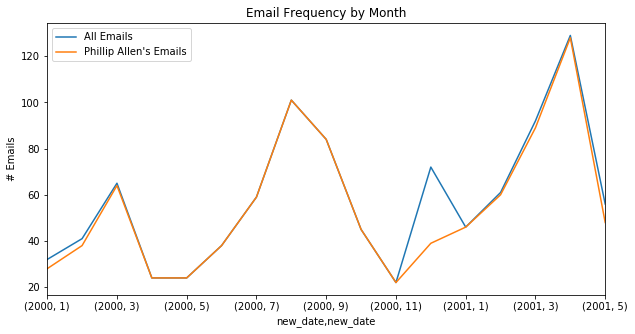

In [9]:
plt.title('Email Frequency by Month')
plt.ylabel('# Emails')
plt.xlabel('Date')

df['From'].groupby([df.new_date.dt.year, df.new_date.dt.month]).count().plot(label="All Emails")
df.loc[df['From'] == "frozenset({'phillip.allen@enron.com'})"]['new_date'].groupby([df.new_date.dt.year, df.new_date.dt.month]).count().plot(label="Phillip Allen's Emails")
plt.legend()

Given that we have the dates and times of these emails, we can also explore any macro time trends in the data. As plotted above, it seems as though Mr. Allen goes through cycles of emails, however it may be an artifact of how this dataset was compiled. The only significant deviation from the emails sent per month, and those sent specifically from Mr. Allen, is in December of the year 2000, though again, it's difficult to infer too much without knowing how these emails were selected. 

## Sentiment and Subjectivity Analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


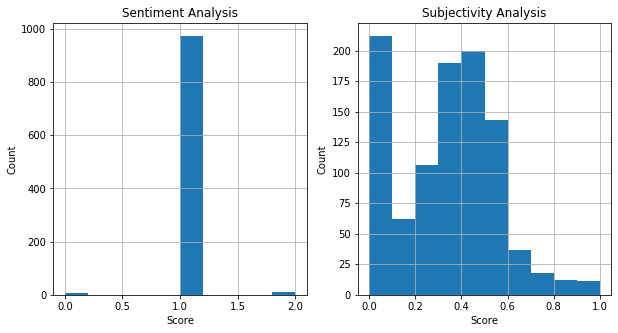

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

def get_tb_subjectivity_score(sent):
    return TextBlob(sent).sentiment.subjectivity
plt.subplot(121)
plt.title('Sentiment Analysis')
plt.xlabel('Score')
plt.ylabel('Count')
df['content'].apply(lambda x: get_vader_score(x)).hist()
plt.subplot(122)
plt.title('Subjectivity Analysis')
plt.xlabel('Score')
plt.ylabel('Count')
df['content'].apply(lambda x: get_tb_subjectivity_score(x)).hist()

We know who's sending emails, and the timeframe we're dealing with, but how about the actual contents. To begin our initial analysis, we can explore if there's any significant variation in sentiment or subjectivity as measured by our fairly basic models. We see that the email contents are overwhelmingly neutral, with a very small number found either negative or positive. For subjectivity however, there's a greater variation, and something that may be worth exploring.

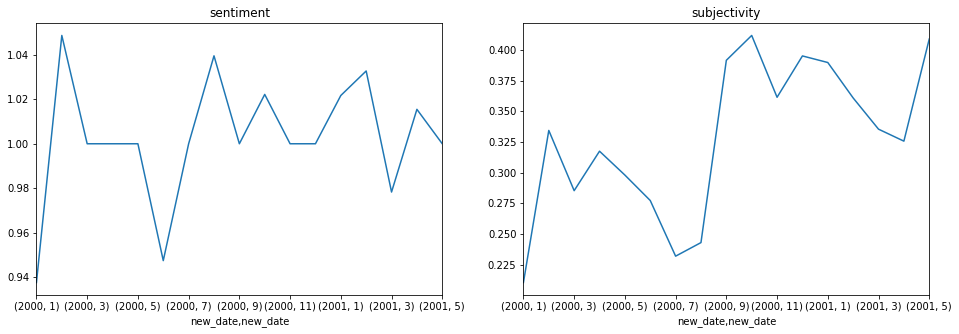

In [11]:
plt.rcParams['figure.figsize'] = [16, 5]
plt.subplot(121)
plt.title("sentiment")
df['content'].fillna("N/A").apply(lambda x: get_vader_score(x)).groupby([df.new_date.dt.year, df.new_date.dt.month]).mean().plot()
plt.subplot(122)
plt.title("subjectivity")
df['content'].fillna("N/A").apply(lambda x: get_tb_subjectivity_score(x)).groupby([df.new_date.dt.year, df.new_date.dt.month]).mean().plot()

Looking at these measures over time, we don't see much change in sentiment, however, we do see a significant jump in subjectivity. There's a marked period from July of 2000 to the fall of that year which indicates an almost doubling of percieved subjectivity in the contents of the emails. This elevated level remained for the rest of the dataset timeframe. With some background knowledge in Enron, it may be possible to correlate these to specific events, but for the purposes of this exercise I'm refraining from doing any outside research that may bias or push me towards certain conclusions. However, it would be interesting to look into!

## Frequency of Words

In [12]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


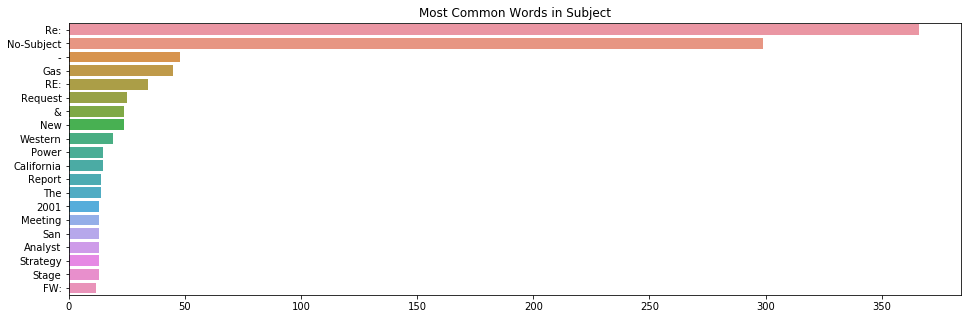

In [13]:
temp = df['Subject'].fillna("No-Subject").str.split().values.tolist()
corpus=[word for i in temp for word in i]

counter=Counter(corpus)
most=counter.most_common()
x, y= [], []
for word,count in most[:100]:
    if (word not in stop):
        x.append(word)
        y.append(count)
x = x[:20]
y = y[:20]
plt.title("Most Common Words in Subject")
sns.barplot(x=y,y=x)

Now we can delve into the individual words and their frequencies. I began by looking at the subject lines, and as expected, it's predominantly empty or replies. There's a few mentions of Gas, Reports, Meetings, and others, but nothing in particular that stands out. One note, for the sake of legibility I have cut out stop words from this.

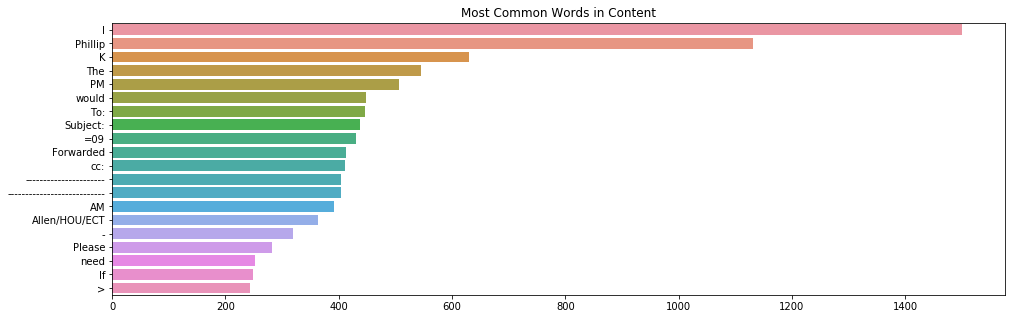

In [14]:
temp = df['content'].fillna("No-Content").str.split().values.tolist()
corpus=[word for i in temp for word in i]

counter=Counter(corpus)
most=counter.most_common()
x, y= [], []
for word,count in most[:100]:
    if (word not in stop):
        x.append(word)
        y.append(count)
x = x[:20]
y = y[:20]
plt.title("Most Common Words in Content")
sns.barplot(x=y,y=x)

The frequencies in the actual email bodies seem a bit more interesting, but not by much. There's the obvious words such as Phillip K Allen/HOU/ECT which are part of his signature, and standard email lingo such as "Subject" and "Forwarded", and a few oddities such as `=09`. Likely part of the email formatting.

In [15]:
print(df.loc[df['content'].str.contains("=09", na=False)]["content"].iloc[3])


---------------------- Forwarded by Phillip K Allen/HOU/ECT on 02/21/2000=
=20
08:06 AM ---------------------------
  =20
=09
=09
=09From:  Jennifer Fraser                           02/19/2000 01:57 PM
=09

To: Stephanie Miller/Corp/Enron@ENRON, Julie A Gomez/HOU/ECT@ECT, Phillip K=
=20
Allen/HOU/ECT@ECT
cc: =20
Subject: PIRA's California/Southwest Gas Pipeline Study

Did any of you order this
JEn

---------------------- Forwarded by Jennifer Fraser/HOU/ECT on 02/19/2000=
=20
03:56 PM ---------------------------


"Jeff Steele" <jsteele@pira.com> on 02/14/2000 01:51:00 PM
To: "PIRA Energy Retainer Client" <jsteele@pira.com>
cc: =20
Subject: PIRA's California/Southwest Gas Pipeline Study





?

PIRA focuses on the  California/Southwest Region in its study of Natural Ga=
s=20
Pipeline  Infrastructure

PIRA  Energy Group announces the continuation of its new multi-client study=
,=20
The  Price of Reliability: The Value and Strategy of Gas  Transportation.

The Price of Reliability, deliv

As expected, the oddities seem to be part of the formatting of the email, some sort of artifact from when the dataset was compiled. If we want any actualy information we'll likely need to dig deeper.

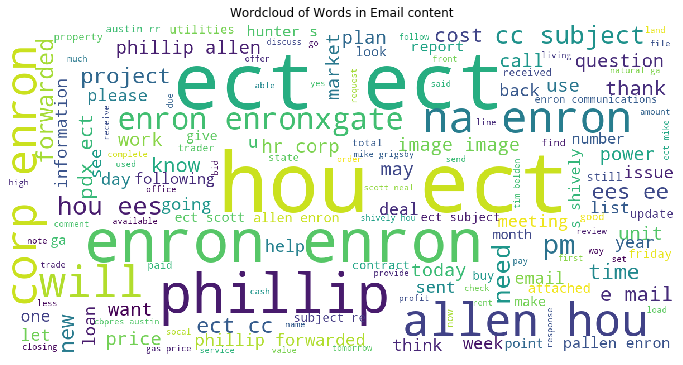

In [16]:
from wordcloud import WordCloud, STOPWORDS
wc_temp = df["content"].str.lower().str.split()
wc_data = [x for sub in wc_temp for x in sub]
wc = WordCloud(background_color = "white", max_words = 1000,  max_font_size = 50, scale=3)
wc.generate(' '.join(wc_data))
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wc)
plt.title("Wordcloud of Words in Email content")
plt.show()

A word cloud reveals fairly obvious phrases and words, with enron, phillip allen, and phillip allens signature taking center stage. Some interesting words such as `encronxgate` and `gas price` which may merit further investigation.

## Named Entity Recognition

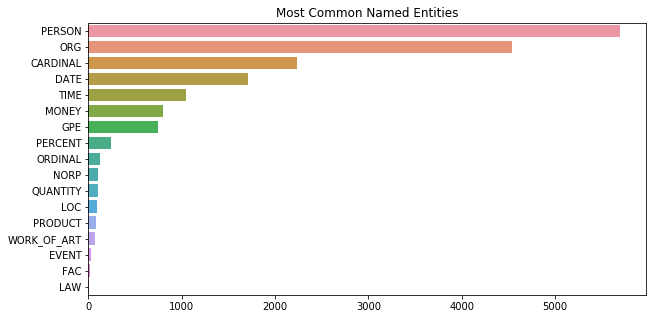

In [17]:
import spacy
nlp = spacy.load("en_core_web_sm")

def ner(text):
    doc = nlp(text)
    return [x.label_ for x in doc.ents]

res = df['content'].apply(lambda x: ner(x))
res = [x for sub in res for x in sub]
counter=Counter(res)
count=counter.most_common()
x,y=map(list,zip(*count))
plt.rcParams['figure.figsize'] = [10, 5]
plt.title("Most Common Named Entities")
sns.barplot(x=y,y=x)

Now that we've done some basic preliminary analysis, we can delve a bit deeper into what these emails contain without having to read every single one. One way to do this is through named entity recognition (NER), digging into the people, places, and organizations these emails are discussing. 

As we can see, People and Organizations dominate the types of entities. People makes sense, as emails are often addressing specific individuals, and organizations likely includes company names, but these are ripe for further analysis.

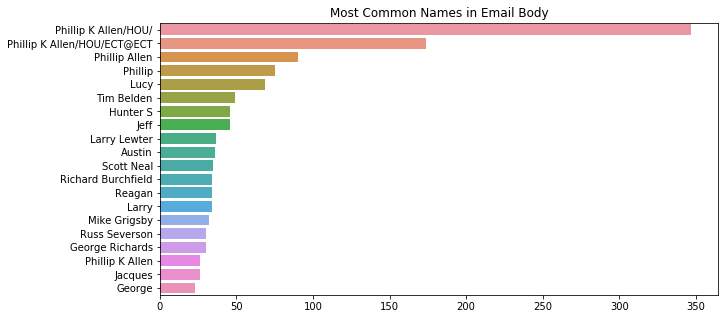

In [18]:
def ner_dive(text, label):
    doc = nlp(text)
    return [x.text for x in doc.ents if x.label_ == label]

res = df['content'].apply(lambda x: ner_dive(x, "PERSON"))
res = [x for sub in res for x in sub]
counter=Counter(res)
count=counter.most_common()
x,y=map(list,zip(*count))
x = x[:20]
y = y[:20]
plt.title("Most Common Names in Email Body")
sns.barplot(x=y,y=x)

Diving into the names first, we can see our favorite email author Phillip K Allen dominates this graph. Likely due to his email signature. Beyond that, we see a handful of other names, Lucy, Tim Belden, Hunter S, and others. These will be important to keep in mind as we keep exploring our dataset, but at least now we have an idea of who's featured in this dataset besides Phillip Allen. 

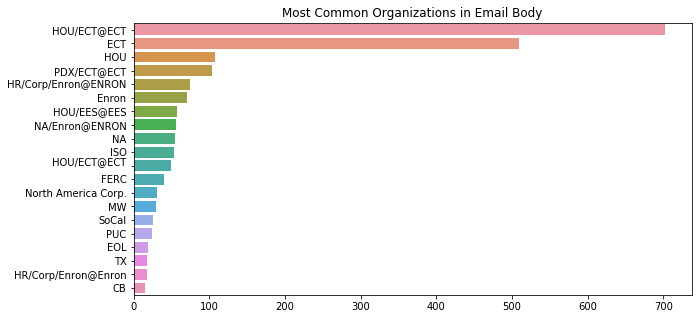

In [19]:
res = df['content'].apply(lambda x: ner_dive(x, "ORG"))
res = [x for sub in res for x in sub]
counter=Counter(res)
count=counter.most_common()
x,y=map(list,zip(*count))
x = x[:20]
y = y[:20]
plt.title("Most Common Organizations in Email Body")
sns.barplot(x=y,y=x)

In terms of organizations, it's dominated by those in email signatures, such as HOU, ENRON, and ECT. There are a few others, such as emails that seem to be from HR and Enron, and other companies such as North America Crop., but nothing stands out immediately. 

## NER On a Per-Email Basis

In [20]:
top_to = df.loc[df['From'] == "frozenset({'phillip.allen@enron.com'})"].groupby('To').size().sort_values(ascending=False).head(10)
print(top_to)
top_to = list(top_to.keys())

To
frozenset({'ina.rangel@enron.com'})          66
frozenset({'stagecoachmama@hotmail.com'})    59
frozenset({'jsmith@austintx.com'})           59
frozenset({'pallen70@hotmail.com'})          40
frozenset({'keith.holst@enron.com'})         37
frozenset({'maryrichards7@hotmail.com'})     30
frozenset({'john.lavorato@enron.com'})       25
frozenset({'cbpres@austin.rr.com'})          22
frozenset({'jacquestc@aol.com'})             22
frozenset({'mike.grigsby@enron.com'})        19
dtype: int64


To get some more interesting insights, we can apply this type of analysis to specific emails. However with so many possible entries, it helps to narrow it down first. I decided to look at Phillip Allen's top correspondence list, and do a deep dive into a select few. 

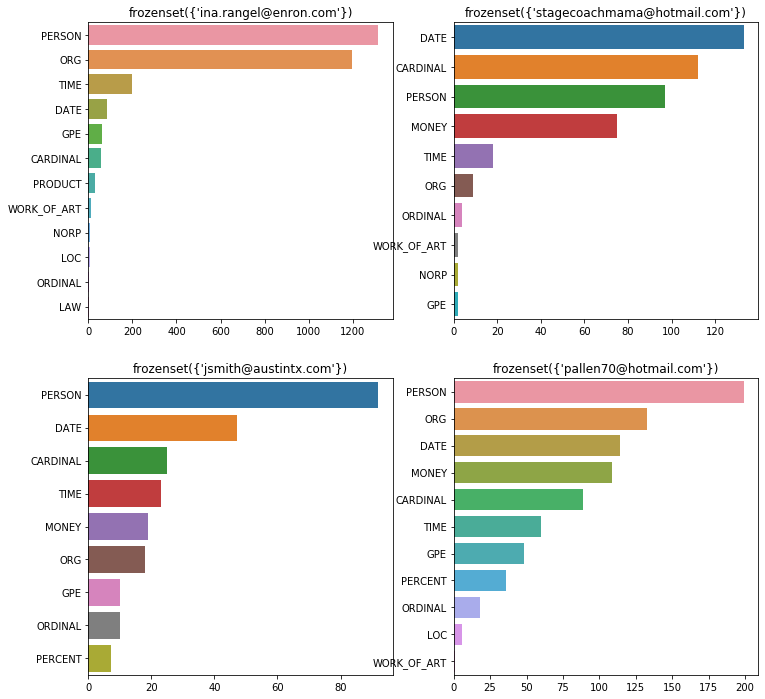

In [21]:
plt.rcParams['figure.figsize'] = [12, 12]
for i in range(4):
    
    res = df.loc[df['To'] == top_to[i]]['content'].apply(lambda x: ner(x))
    res = [x for sub in res for x in sub]
    counter=Counter(res)
    count=counter.most_common()
    x,y=map(list,zip(*count))
    
    plt.subplot(221+i)
    plt.title(top_to[i])
    sns.barplot(x=y,y=x)

Upon doing a deeper NER analysis on Phillip Allen's top 4 "to" email addresses, we start to see some interesting information. Most of these have very similar structures to our overall analysis, containing primarily Names and organizations, however one stands out. `stagecoachmama@hotmail.com`, with its unprofessional email address alone, stands out in dramatic fashion. Rather than names or organizations, correspondence revolves around dates, numbers, and money. This anomolous behavior deserves a deeper look.

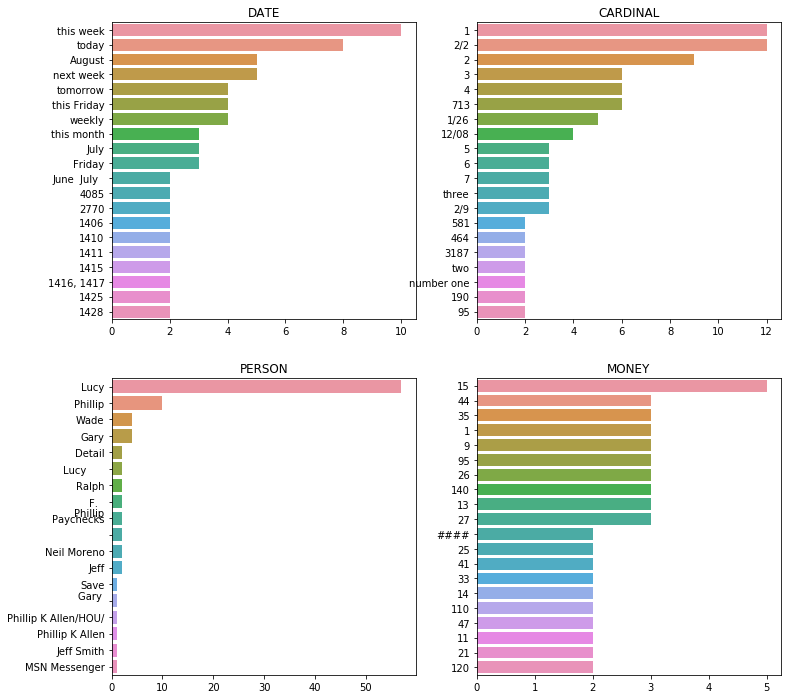

In [22]:
plt.rcParams['figure.figsize'] = [12, 12]
topics = ["DATE", "CARDINAL", "PERSON", "MONEY"]
for t in range(len(topics)):
    res = df.loc[df['To'] == "frozenset({'stagecoachmama@hotmail.com'})"]['content'].apply(lambda x: ner_dive(x, topics[t]))
    res = [x for sub in res for x in sub]
    counter=Counter(res)
    count=counter.most_common()
    x,y=map(list,zip(*count))
    
    x = x[:20]
    y = y[:20]
    
    plt.subplot(221+t)
    plt.title(topics[t])
    sns.barplot(x=y,y=x)

A lot of this deeper dive into `stagecoachmama` doesn't seem too interesting. A lot of numbers and vague references to time, however the Person category stands out. Judging by the overwhelming number of emails that refer to Lucy, it's relatively safe to say that this is the name behind the email.

In [23]:
df.loc[df['content'].str.contains("Lucy", na=False)].groupby(["From", "To"]).size()

From                                    To                                       
frozenset({'phillip.allen@enron.com'})  frozenset({'jsmith@austintx.com'})            1
                                        frozenset({'pallen70@hotmail.com'})          13
                                        frozenset({'pallen@hotmail.com'})             1
                                        frozenset({'stagecoachmama@hotmail.com'})    57
dtype: int64

Not too many emails refer to Lucy, other than `pallen70@hotmail.com` and `pallen@hotmail.com` which seem like other email address for Phillip Allen. However we have an email address that doesn't fit this pattern, `jsmith@austintx.com`. Given that it's a single email we can simply print it out.

## Individual Email Dive

In [24]:
email = df.loc[(df['content'].str.contains("Lucy", na=False)) & (df['To']=="frozenset({'jsmith@austintx.com'})")]["content"].iloc[0]
print(email)

Jeff,

That is good news about Leander.  

Now for the stage.  I would like to get it sold by the end of March.   I have 
about $225K invested in the stagecoach, 
 it looks like I need to get around $745K to breakeven.  

I don't need the cash out right now so if I could get a personal guarantee 
and Jaques Craig can 
work out the partnership transfer, I would definitely be willing to carry a 
second lien.  I understand second liens are going for 10%-12%.
Checkout this spreadsheet.





These numbers should get the place sold in the next fifteen minutes.   
However,  I am very concerned about the way it is being shown.  Having Lucy 
show it is not a good idea.  I need you to meet the buyers and take some 
trips over to get more familar with the property.  My dad doesn't have the 
time and I don't trust 
Lucy or Wade to show it correctly.  I would prefer for you to show it from 
now on.  

I will have the operating statements complete through December by this 
Friday. 


Phillip







This is the first email that I'll dive into, one that refers to Lucy without being to `stagecoachmama` or an email alias. Judging by the contents of this email, it seems as though Phillip is quite literally trying to sell a stagecoach, one that he's invested quite a bit of time and money into. This would certainly explain why they may be emailing someone with the username `stagecoachmama`. It's possible also that this refers to some kind of real estate deal judging by the language. However let's find out who exactly Lucy is, and what their relationship to Phillip is.

In [25]:
stagecoachmama = df.loc[(df['content'].str.contains("Lucy", na=False)) & (df['To']=="frozenset({'stagecoachmama@hotmail.com'})")]["content"].iloc[0:3]
for e in stagecoachmama:
    print(e)

Lucy,

 Here are the rentrolls:



 Open them and save in the rentroll folder.  Follow these steps so you don't 
misplace these files.

 1.  Click on Save As
 2.  Click on the drop down triangle under Save in:
 3.  Click on the  (C): drive
 4.  Click on the appropriate folder
 5.  Click on Save:

Phillip
Lucy,

I want to have an accurate rent roll as soon as possible. I faxed you a copy 
of this file.  You can fill in on the computer or just write in the correct 
amounts and I will input.

Lucy,


You wrote fewer checks this month.  Spent more money on Materials and less on 
Labor.


   June  July  August

Total Materials  2929  4085  4801

Services  53  581  464

Labor   3187  3428  2770






Here are my questions on the August bank statement (attached):

1.  Check 1406  Walmart    Description and unit?

2.  Check 1410  Crumps     Detail description and unit?

3.  Check 1411  Lucy      What is this?

4.  Check 1415  Papes      Detail description and units?

5.  Checks 1416, 1417, and

Judging by these emails, it seems that Phillip and Lucy either manage or own properties together, and also seem to be doing some sort of construction or renovation. As for why Phillip is handling these through his work emails, who knows, but at least we now have a better idea of how he was spending his time and who he was interacting with.

## Topic Analysis

We can pull back a bit and look again from a broader view, and see if we can group these documents by specific topics.  

In [26]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim

def preprocess(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for row in df["content"]:
        words=[w for w in word_tokenize(row) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess(df)
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [28]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dic)
lda_model.show_topics()

[(0,
  '0.038*"ECT" + 0.017*"EnronXGate" + 0.014*"Phillip" + 0.008*"Enron" + 0.007*"Allen/HOU/ECT" + 0.006*"ENRON" + 0.005*"Please" + 0.005*"Subject" + 0.004*"gas" + 0.004*"Forwarded"'),
 (1,
  '0.010*"would" + 0.009*"Phillip" + 0.009*"The" + 0.004*"E-mail" + 0.004*"ECT" + 0.003*"n\'t" + 0.003*"project" + 0.003*"price" + 0.003*"Please" + 0.003*"http"'),
 (2,
  '0.015*"ECT" + 0.012*"Phillip" + 0.011*"ENRON" + 0.006*"Enron" + 0.006*"Allen/HOU/ECT" + 0.005*"need" + 0.005*"EES" + 0.005*"know" + 0.005*"would" + 0.004*"The"'),
 (3,
  '0.030*"=09" + 0.018*"ECT" + 0.017*"Phillip" + 0.014*"ENRON" + 0.009*"IMAGE" + 0.006*"Enron" + 0.005*"Allen/HOU/ECT" + 0.005*"Buy" + 0.004*"Forwarded" + 0.004*"The"'),
 (4,
  '0.020*"ECT" + 0.014*"Phillip" + 0.010*"The" + 0.006*"would" + 0.006*"Allen/HOU/ECT" + 0.005*"loan" + 0.005*"Forwarded" + 0.004*"Subject" + 0.004*"Enron" + 0.004*"project"'),
 (5,
  '0.013*"Phillip" + 0.012*"ECT" + 0.012*"=09" + 0.006*"The" + 0.006*"Subject" + 0.006*"would" + 0.005*"Allen/H

We've utilized an LDA model to generate what it believes are the best distinct categories in our dataset. As can be seen, there's a lot of overlap between common words such as Phillip, Enron, HOU/ECT, etc. 10 different categories may actually be too many for what is looking like a relatively homogenous dataset. 

In [30]:
%matplotlib inline
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
#vis

A visualization of our model, projected down to 2 dimensions utilizing PCA. Here it becomes clearer where our various topics overlap and where they do not.

In [31]:
def preprocess_single(text):
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    words=[w for w in word_tokenize(text) if (w not in stop)]
    words=[lem.lemmatize(w) for w in words if len(w)>2]
    return words

inp = dic.doc2bow(preprocess_single(email))
res = lda_model[inp]
for r in res:
    print("Score: {} Topic: {} Details: {}".format(r[1],r[0],lda_model.print_topic(r[0], 3)))

Score: 0.2771432101726532 Topic: 5 Details: 0.013*"Phillip" + 0.012*"ECT" + 0.012*"=09"
Score: 0.714242696762085 Topic: 8 Details: 0.016*"Phillip" + 0.014*"ECT" + 0.010*"Allen/HOU/ECT"


As a quick test we can see where our earlier email discussing the stagecoach would be classified based on our model, and see the specific keywords that land it in that category. It looks fairly broad however so the value of this specific topic analysis isn't particularly striking.

## "To" Classification with Transformers

Now lets see if we can create another model based off of what we have. More speecifically, given the content of an email, can we predict who it was sent to?

label
0     AxesSubplot(0.125,0.125;0.775x0.755)
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
15    AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
17    AxesSubplot(0.125,0.125;0.775x0.755)
18    AxesSubplot(0.125,0.125;0.775x0.755)
19    AxesSubplot(0.125,0.125;0.775x0.755)
Name: label, dtype: object

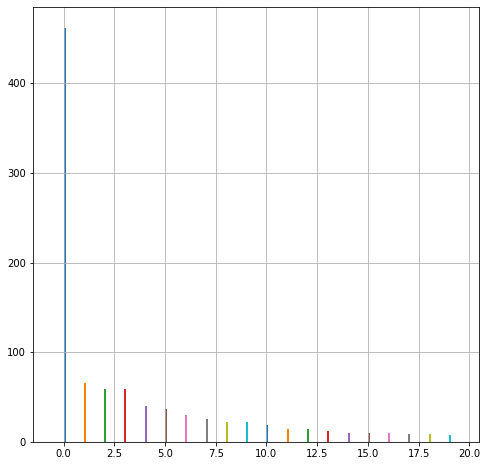

In [33]:
from sklearn import preprocessing 
import os

train_df = df[df['From'] == "frozenset({'phillip.allen@enron.com'})"][['To', 'content']]
train_df.To = pd.Categorical(train_df.To)
train_df['label'] = 0
num_labels = 19
top = df.groupby('To').size().sort_values(ascending=False).head(num_labels).keys().tolist()
for x in range(num_labels):
    train_df.loc[train_df['To'] == top[x], 'label'] = x+1

from sklearn.model_selection import train_test_split

train, test = train_test_split(train_df, test_size=0.2)

plt.rcParams['figure.figsize'] = [8, 8]
train_df.groupby('label')['label'].hist()

We create 20 labels, 19 are specific to the most commonly sent to individuals while the rest are lumped under an "other" label. This gives us a distribution of about 50% other and the remaining 50% split between the 19 individuals. This is a fairly unbalanced dataset, but it'll provide an interesting vehicle with which to test the possibility of classification. We then split the data set into a training set and a 20% holdout testing set.

In [34]:
from transformers import DistilBertTokenizerFast
tokenizer =DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train['content'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test['content'].tolist(), truncation=True, padding=True)

We tokenize our text to prepare it for the model

In [35]:
import torch
print(torch.cuda.get_device_name(0))
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

GeForce RTX 2060


Create a basic dataset class and verify we're using our GPU

In [36]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc
    }

Set up some additional metrics. Due to it being multi-label classification, we stick to just accuracy for now.

In [37]:
train_dataset = Dataset(train_encodings, train['label'].tolist())
test_dataset = Dataset(test_encodings, test['label'].tolist())

Set up our datasets and train!

In [38]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=4,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs/',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy="steps",
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels+1)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset ,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Step,Training Loss,Validation Loss,Accuracy
100,2.757870,2.295587,0.478723
200,2.109670,1.979858,0.478723
300,1.811710,1.708309,0.537234
400,1.455004,1.457974,0.585106
500,1.207240,1.142920,0.728723
600,0.965653,1.044448,0.744681
700,0.597807,0.928865,0.797872


TrainOutput(global_step=752, training_loss=1.4975116151444456)

In [39]:
class PredDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, length):
        self.encodings = encodings
        self.length = length

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return self.length

Now we can start looking at our model and what sort of predictions it's giving off with some confusion matrices.

(188,)
188


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


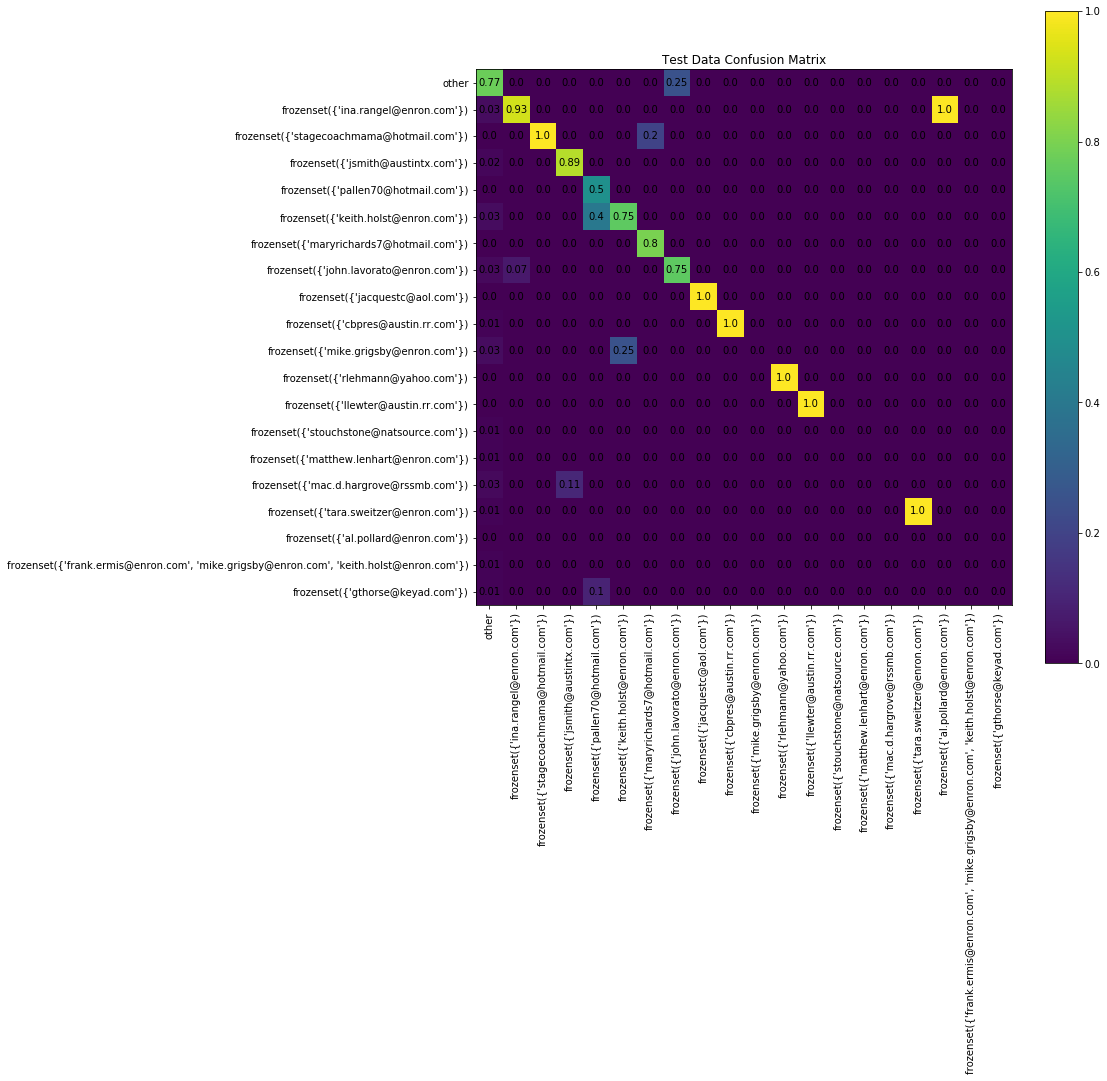

In [40]:
from sklearn.metrics import confusion_matrix

pred = trainer.predict(PredDataset(test_encodings, len(test['label'].tolist()))).predictions.argmax(-1)
print(pred.shape)
print(len(test['label'].tolist()))
cm = confusion_matrix(test['label'], pred)
plt.rcParams['figure.figsize'] = [12, 12]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.yticks(list(range(20)))
plt.xticks(list(range(20)), rotation=90)
ax.set_yticklabels(["other"]+top)
ax.set_xticklabels(["other"]+top)
plt.imshow(np.nan_to_num(cm/cm.astype(np.float).sum(axis=0)))
for (j,i),label in np.ndenumerate(np.nan_to_num(cm/cm.astype(np.float).sum(axis=0))):
    ax.text(i,j,round(label, 2),ha='center',va='center')
plt.colorbar()
plt.title("Test Data Confusion Matrix")
plt.show()

(749,)
749


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


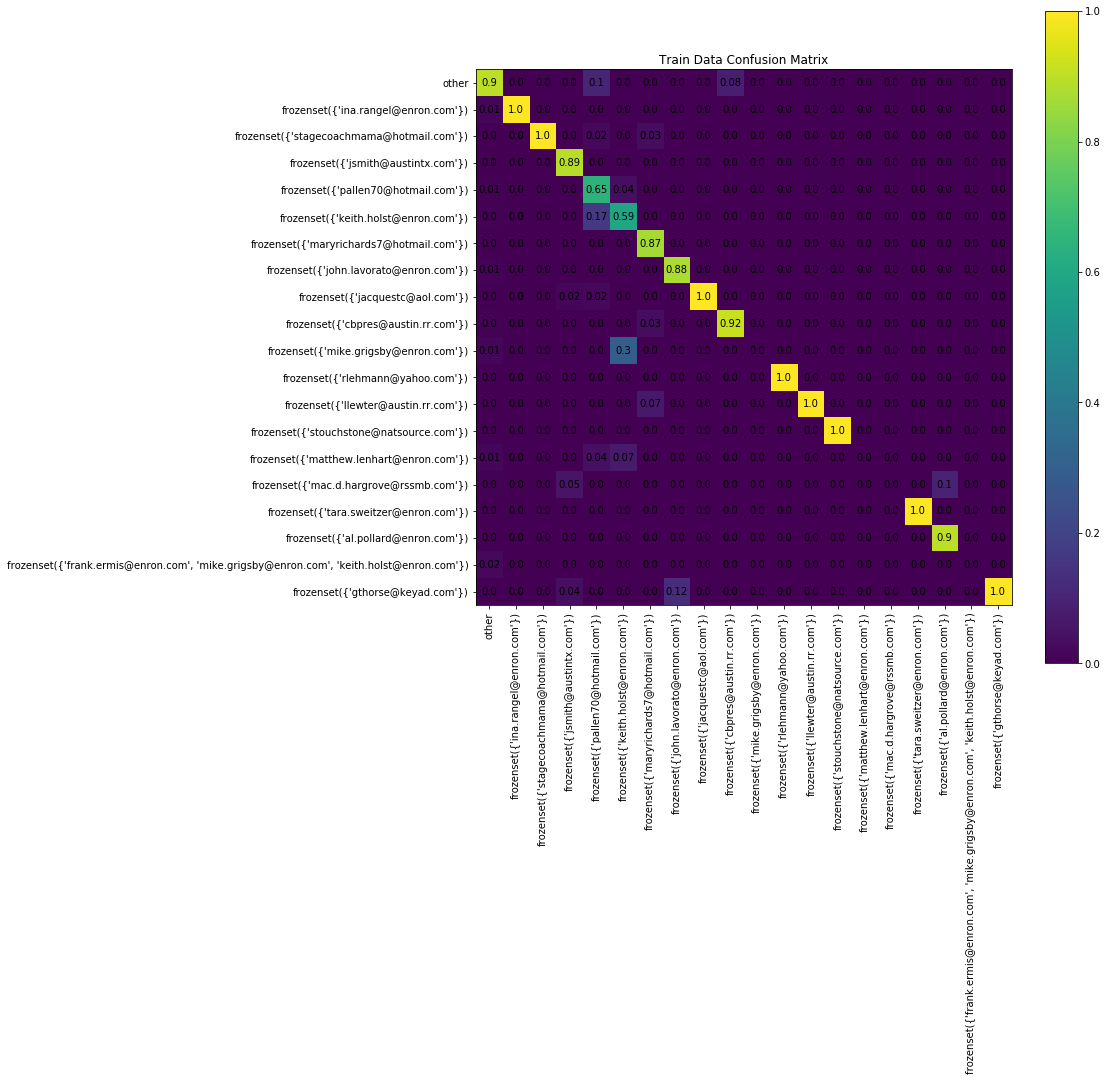

In [41]:
pred = trainer.predict(PredDataset(train_encodings, len(train['label'].tolist()))).predictions.argmax(-1)
print(pred.shape)
print(len(train['label'].tolist()))
cm = confusion_matrix(train['label'], pred)
plt.rcParams['figure.figsize'] = [12, 12]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.yticks(list(range(20)))
plt.xticks(list(range(20)), rotation=90)
ax.set_yticklabels(["other"]+top)
ax.set_xticklabels(["other"]+top)
plt.imshow(np.nan_to_num(cm/cm.astype(np.float).sum(axis=0)))
for (j,i),label in np.ndenumerate(np.nan_to_num(cm/cm.astype(np.float).sum(axis=0))):
    ax.text(i,j,round(label, 2),ha='center',va='center')
plt.colorbar()
plt.title("Train Data Confusion Matrix")
plt.show()

Looks like it performs decently well on both the train and the test datasets, even with such a high imbalance between the classes. Of course this can always be improved, but it seems like a decent start. I wouldn't say we can predict who he's going to send an email to with an extreme degree of confidence, but it at least seems feasible.

Something interesting of note is the oddly high level of confusion between `pallen70@hotmail` and `keith.holst@enron`. I wouldn't read too much into it, but if we had more time it'd be interesting to pull up some email examples and determine why there's confusion. Lot of data, but only so much time!